In [1]:
%matplotlib inline

In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import gzip
import re

In [4]:
def parse_line(l):
    if l[0] == '#': 
        return None
    if len(l) < 33:
        #print("ERROR: "+l)
        return None
    return {
        "task": re.sub("^ *", "", l[0:16]),
        "pid": int(re.sub(" +$", "", l[17:22])),
        "cpu": int(l[24:27]),
        "irq_off": l[29],
        "need_resched": l[30],
        "hardirq_softirq": l[31],
        "preempt_depth": int(l[32]),
        "timestamp": float(l[33:45]),
        "function": re.sub(":.*", "", l[48:])[:-1],
        "arguments": re.sub("[^:]+:", "", l[48:])[:-1]
    }

In [5]:
def load_log(tracefile):
    with gzip.open(tracefile) as f:
        return [
            line for line in [
            parse_line(line.decode()) 
            for line 
            in f
            ] if line != None
        ]

In [6]:
log = load_log("delay_tracefiles/delay_real_1ms/YCSB_WorkloadA_TimingAsql.log.gz")

In [7]:
set([line["function"] for line in log])

{'block_rq_complete',
 'block_rq_insert',
 'cpufreq_interactive_already',
 'cpufreq_interactive_notyet',
 'cpufreq_interactive_setspeed',
 'cpufreq_interactive_target',
 'sched_switch',
 'tracing_mark_write'}

In [8]:
def extract(trace):
    freq = [
        [ line["timestamp"], line["cpu"], int(re.match(r".*actual=([0-9]+)", line["arguments"])[1]) ]
        for line in trace
        if line["function"].startswith("cpufreq")
    ]
    app = [
        line
        for line in trace
        if line["task"] == "chmark_withjson"
    ]
    query_state = [
        [line["timestamp"], 1 if re.match(".*(SQL_START|DELAY_end)", line["arguments"]) else 0, line["arguments"]]
        for line in app
        if re.match(".*(DELAY_|SQL_)", line["arguments"])
        and line["function"] == "tracing_mark_write"
    ]
    start, end = [
        line["timestamp"]
        for line in log
        if line["function"] == "tracing_mark_write"
        and re.match(".*(a|A)pp", line["arguments"])
    ]
    return [freq, app, query_state, start, end]

In [9]:
freq, app, query_state, start, end = extract(log)

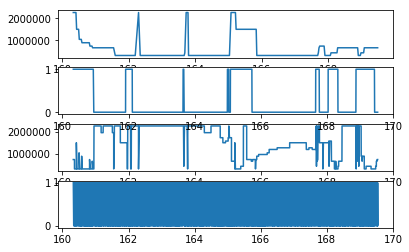

In [10]:
fig = plt.figure()
ax = fig.add_subplot(413)
ax.plot(
    [x[0] for x in freq if x[1] == 0 and x[0] >= start and x[0] <= end],
    [x[2] for x in freq if x[1] == 0 and x[0] >= start and x[0] <= end]
)
ax = fig.add_subplot(411)
ax.plot(
    [x[0] for x in freq if x[1] == 1 and x[0] >= start and x[0] <= end],
    [x[2] for x in freq if x[1] == 1 and x[0] >= start and x[0] <= end]
)
ax = fig.add_subplot(412)
ax.plot(
    [x["timestamp"] for x in app if x["timestamp"] >= start and x["timestamp"] <= end],
    [x["cpu"] for x in app if x["timestamp"] >= start and x["timestamp"] <= end]
)
ax = fig.add_subplot(414)
ax.plot(
    [x[0] for x in query_state],
    [x[1] for x in query_state]
)
plt.show()

In [11]:
def build_trace(log):
    freq, app, query_state, start, end = extract(log)
    return sorted([
        [x[0], { "event" : "freq", "core" : x[1], "freq" : x[2] }]
        for x in freq
    ] + [
        [x["timestamp"], { "event" : "core", "core" : x["cpu"] }]
        for x in app
    ] + [
        [x[0], { "event" : "query", "state" : x[1] == 1 }]
        for x in query_state
    ], key = lambda x : x[0])
trace = build_trace(log)

In [19]:
def compute_cycle_use(trace):
    freq = [2265600, 2265600, 2265600, 2265600]
    app_core = 0
    in_query = False
    last_ts = None
    cumulative_time = 0
    cumulative_cycles = 0
    freq_events = []
    in_query_freq_events = []
    for event in trace:
        ts, desc = event
        if in_query and (not "core" in desc or desc["core"] == app_core):
            delta_ts = ts - last_ts
            cumulative_time += delta_ts
            cumulative_cycles += delta_ts * freq[app_core]
            freq_events.append([ts, freq[app_core]])
        if(desc["event"] == "freq"): 
            freq[desc["core"]] = desc["freq"]
            if in_query:
                in_query_freq_events.append(ts)
        elif(desc["event"] == "core"):
            app_core = desc["core"]
        elif(desc["event"] == "query"):
            in_query = desc["state"]
        else:
            raise "Invlalid event: " +str(desc["event"])
        last_ts = ts
    return [cumulative_time, cumulative_cycles, cumulative_cycles / cumulative_time, freq_events, in_query_freq_events] 
time, cycles, speed, freq_events, in_query_freq_events = compute_cycle_use(trace)
[time, cycles, speed]

[6.3726299999995035, 9907635.8399991, 1554716.9441815815]

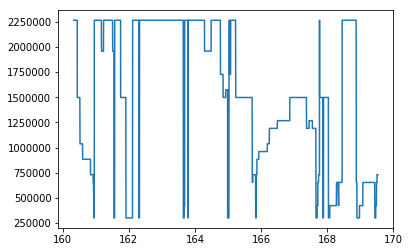

In [17]:
plt.plot([x[0] for x in freq_events], [x[1] for x in freq_events])

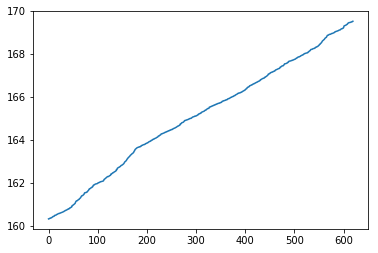

In [20]:
plt.plot(in_query_freq_events)

In [21]:
def load_pair(workload):
    return {
        "real" : load_log("delay_tracefiles/delay_real_1ms/"+workload+".log.gz"),
        "clean" : load_log("delay_tracefiles/delay_clean_1ms/"+workload+".log.gz")
    }

In [22]:
pair_data = load_pair("YCSB_WorkloadB_TimingAsql")

In [25]:
real_stats = compute_cycle_use(build_trace(pair_data["real"]))
clean_stats = compute_cycle_use(build_trace(pair_data["clean"]))
[real_stats[0:3], clean_stats[0:3]]

[[3.728839999999991, 4016552.736000411, 1077158.7775287812],
 [1.938839999999857, 4392635.903999674, 2265599.999999999]]

In [26]:
workloads = [ 
    "YCSB_WorkloadA_TimingA", 
    "YCSB_WorkloadB_TimingA", 
    "YCSB_WorkloadC_TimingA", 
    "YCSB_WorkloadD_TimingA", 
    "YCSB_WorkloadE_TimingA", 
    "YCSB_WorkloadF_TimingA"
]

systems = [
    "sql", "bdb"
]

workload_system_pair_data = [
    [w+s, load_pair(w+s)] for w in workloads for s in systems
]

In [70]:
workload_stats = [ 
    [pair_data[0], [
       compute_cycle_use(build_trace(pair_data[1]["real"])),
       compute_cycle_use(build_trace(pair_data[1]["clean"]))
    ]]
    for pair_data in workload_system_pair_data
]
workload_stats = dict(workload_stats)


In [99]:
def title_of_workload(w):
    return re.sub("YCSB_Workload(.)_TimingA", "YCSB Workload \\1", w)

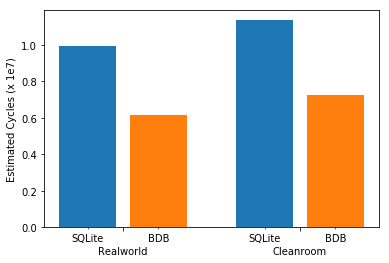

In [95]:
def get_cycles(w):
    return [w[0][1], w[1][1]]

def plot_workload(w):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar([1, 3.5], [ x / 1e7 for x in get_cycles(workload_stats[w+"sql"])])
    ax.bar([2, 4.5], [ x / 1e7 for x in get_cycles(workload_stats[w+"bdb"])])
    ax.set_xticks((1, 2, 3.5, 4.5), minor=True)
    ax.set_xticklabels( ('SQLite', 'BDB', 'SQLite', 'BDB'), minor=True )
    ax.set_xticks((1.5, 4))
    ax.set_xticklabels( ('\nRealworld', '\nCleanroom') )
    ax.set_ylabel("Estimated Cycles (x 1e7)")
    plt.show()
    
plot_workload(workloads[0])

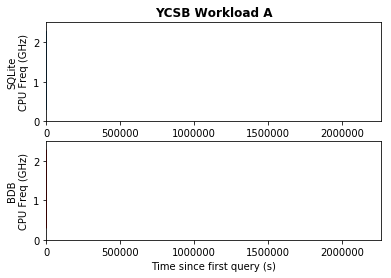

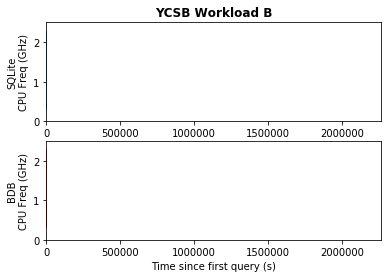

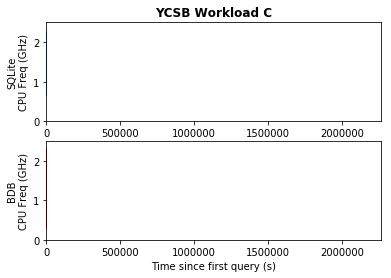

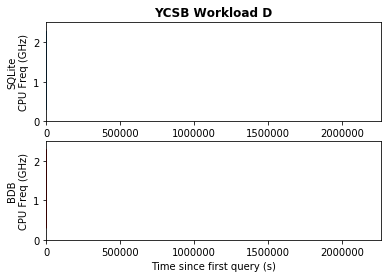

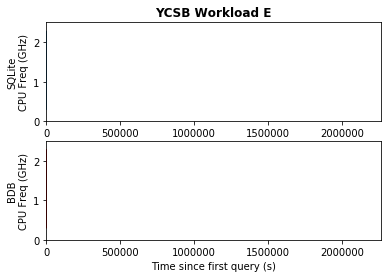

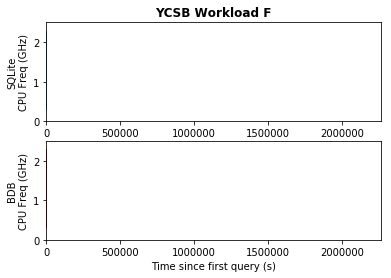

In [112]:
def plot_freq_timeline(w):
    sqlite_freq_events = workload_stats[w+"sql"][0][3]
    bdb_freq_events = workload_stats[w+"bdb"][0][3]
    
    max_x = max(sqlite_freq_events[0][-1], bdb_freq_events[0][-1])
    fig = plt.figure()
    ax = fig.add_subplot(211)
    ax.set_title(title_of_workload(w), fontweight='bold')
    ax.plot(
        [x[0] - sqlite_freq_events[0][0] for x in sqlite_freq_events], 
        [x[1]/(1000*1000) for x in sqlite_freq_events]
    )
    ax.set_ylabel("SQLite\nCPU Freq (GHz)")
    ax.set_ylim([0, 2.5])
    ax.set_xlim([0, max_x])
    ax = fig.add_subplot(212)
    ax.plot(
        [x[0] - bdb_freq_events[0][0] for x in bdb_freq_events], 
        [x[1]/(1000*1000) for x in bdb_freq_events],
        color = 'r'
    )
    ax.set_ylabel("BDB\nCPU Freq (GHz)")
    ax.set_xlabel("Time since first query (s)")
    ax.set_ylim([0, 2.5])
    ax.set_xlim([0, max_x])
    plt.show()

for w in workloads:
    plot_freq_timeline(w)


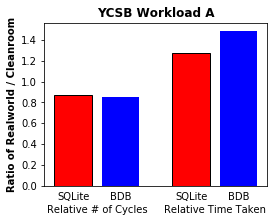

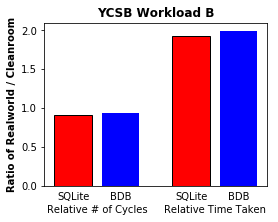

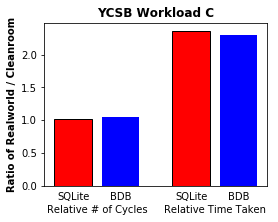

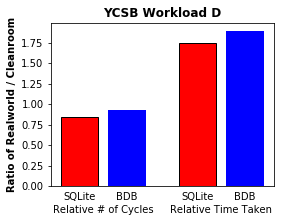

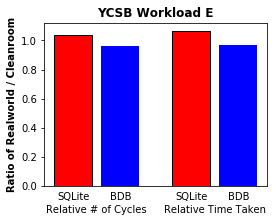

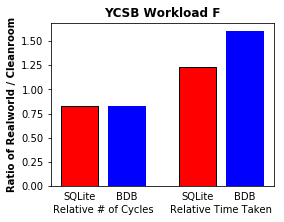

In [104]:
def get_offsets(w):
    return [
        float(w[0][1])/float(w[1][1]), #relative cycles
        float(w[0][0])/float(w[1][0]) #relative time
    ]

def plot_offsets(w):
    fig = plt.figure(figsize=(4, 3))
    ax = fig.add_subplot(111)
    ax.bar([1, 3.5], get_offsets(workload_stats[w+"sql"]), color="r", linewidth=1, edgecolor="k")
    ax.bar([2, 4.5], get_offsets(workload_stats[w+"bdb"]), color="b")
    ax.set_xticks((1, 2, 3.5, 4.5), minor=True)
    ax.set_xticklabels( ('SQLite', 'BDB', 'SQLite', 'BDB'), minor=True )
    ax.xaxis.set_ticks_position('none') 
    ax.set_xticks((1.5, 4))
    ax.set_xticklabels( ('\nRelative # of Cycles', '\nRelative Time Taken') )
    ax.set_ylabel("Ratio of Realworld / Cleanroom", fontweight='bold')
    fig.savefig(w+"-relative_perf.pdf", bbox_inches='tight')
    ax.set_title(title_of_workload(w), fontweight='bold')
    plt.show()


for w in workloads:
    plot_offsets(w)